In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.tree import plot_tree


np.random.seed(0)


num_rows = 50
num_columns = 3


random_data = pd.DataFrame(np.random.rand(num_rows, num_columns), 
                            columns=[f'Column_{i+1}' for i in range(num_columns)])



rd = random_data.copy() 

print(rd.head())
x1 = 'Column_1'
x2 = 'Column_2'
y0 = 'Column_3'
X_cols = [x1, x2]
rd[x1] = np.sin(rd[x1]) ** 2
rd[x2] = np.cos(rd[x2]) ** 2
rd[y0] = rd[y0] * rd[x1] * rd[x2]

print(rd.head())

min_samples = 2
max_depth = 3

   Column_1  Column_2  Column_3
0  0.548814  0.715189  0.602763
1  0.544883  0.423655  0.645894
2  0.437587  0.891773  0.963663
3  0.383442  0.791725  0.528895
4  0.568045  0.925597  0.071036
   Column_1  Column_2  Column_3
0  0.272145  0.569978  0.093499
1  0.268654  0.831001  0.144197
2  0.179569  0.394426  0.068253
3  0.139961  0.493673  0.036544
4  0.289428  0.361631  0.007435


In [2]:
class Node:
    def __init__(self, data, depth):
        self.data = data
        self.depth = depth
        self.left = None
        self.right = None
        self.split_j = None
        self.split_s = None
        self.prediction = None

    def __repr__(self):
        return f"Node(depth={self.depth}, samples={len(self.data)}, split={self.split_j} <= {self.split_s}, prediction={self.prediction})"

In [3]:
def predictors(X, y, dataset):
    best_j, best_s, best_rss = None, None, float('inf')

    for col in dataset.columns:
        if col == y:
            continue

        sorted_vals = dataset.sort_values(by=col)
        sorted_y = sorted_vals[y]

        for i in range(1, len(sorted_vals)):
            if sorted_vals[col].iloc[i] != sorted_vals[col].iloc[i-1]:
                s = np.mean([sorted_vals[col].iloc[i], sorted_vals[col].iloc[i-1]])
                left_side = dataset[col] <= s
                right_side = ~left_side

                left_rss = np.sum((dataset[y][left_side] - np.mean(dataset[y][left_side])) ** 2)
                right_rss = np.sum((dataset[y][right_side] - np.mean(dataset[y][right_side])) ** 2)

                rss = left_rss + right_rss

                if rss < best_rss:
                    best_j, best_s, best_rss = col, s, rss
                
    return best_j, best_s, best_rss

best_j, best_s, best_rss = predictors(X_cols, y0, rd)
print(best_j, best_s, best_rss)

Column_1 0.28960419001050275 0.37035124861396507


In [4]:
def recursive(X, y, dataset, depth=0):
    samples = len(dataset)
    node = Node(dataset, depth)
    
    if depth >= max_depth or samples < min_samples:
        return node
    
    best_j, best_s, best_rss = predictors(X, y, dataset)
    if (best_j is None) or (best_s is None):
        print("No valid split found. Stopping recursion.")
        return node
        
    node.split_j = best_j
    node.split_s = best_s
    node.prediction = np.mean(node.data)
    left_split = dataset[dataset[best_j] <= best_s]
    right_split = dataset[dataset[best_j] > best_s]
    
    print(f"\nDepth: {depth}, Best Split: {best_j} <= {best_s}")
    print(f"\nLeft Split Size: {len(left_split)}, Right Split Size: {len(right_split)}")
        
    node.left = recursive(X, y, left_split, depth+1)
    node.right = recursive(X, y, right_split, depth+1)

    print(f"\n\nDepth = {depth}")
    print(f"\n\nNumber of Samples = {samples}")
    print(f"\n\nRegion: {node.data.head()}")
    print(f"\n\n{node.__repr__()}")
    return node
    
root = recursive(X_cols, y0, rd)


Depth: 0, Best Split: Column_1 <= 0.28960419001050275

Left Split Size: 27, Right Split Size: 23

Depth: 1, Best Split: Column_1 <= 0.11361263257922766

Left Split Size: 18, Right Split Size: 9

Depth: 2, Best Split: Column_1 <= 0.022016233944578203

Left Split Size: 9, Right Split Size: 9


Depth = 2


Number of Samples = 18


Region:     Column_1  Column_2  Column_3
5   0.007572  0.999591  0.006302
8   0.013924  0.643433  0.001284
10  0.068372  0.511164  0.015942
16  0.096239  0.873446  0.047930
18  0.042999  0.974204  0.027358


Node(depth=2, samples=18, split=Column_1 <= 0.022016233944578203, prediction=0.27088959114750605)

Depth: 2, Best Split: Column_2 <= 0.5318257997702815

Left Split Size: 4, Right Split Size: 5


Depth = 2


Number of Samples = 9


Region:    Column_1  Column_2  Column_3
0  0.272145  0.569978  0.093499
1  0.268654  0.831001  0.144197
2  0.179569  0.394426  0.068253
3  0.139961  0.493673  0.036544
4  0.289428  0.361631  0.007435


Node(depth=2, samples=9, spl

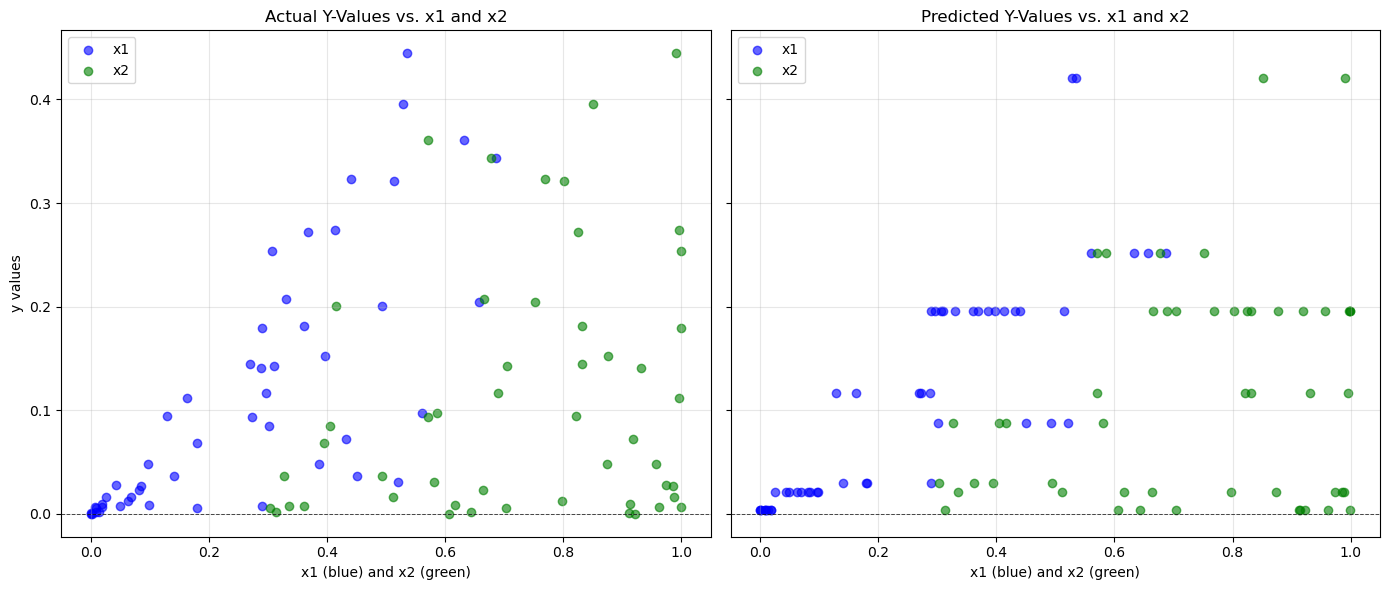

In [5]:
def collect_predictions(node, results=None):
    if results is None:
        results = []


    if node.left is None and node.right is None:
        for _, row in node.data.iterrows():
            results.append((row[x1], row[x2], np.mean(node.data[y0])))


    if node.left:
        collect_predictions(node.left, results)
    if node.right:
        collect_predictions(node.right, results)
    
    return results

results = collect_predictions(root)

predictions_df = pd.DataFrame(results, columns=['x1', 'x2', 'y_pred'])

actual_df = rd[[x1, x2, y0]].copy()
actual_df.columns = ['x1', 'x2', 'y_actual']

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].scatter(actual_df['x1'], actual_df['y_actual'], color='blue', alpha=0.6, label='x1')
axes[0].scatter(actual_df['x2'], actual_df['y_actual'], color='green', alpha=0.6, label='x2')
axes[0].set_title("Actual Y-Values vs. x1 and x2")
axes[0].set_xlabel("x1 (blue) and x2 (green)")
axes[0].set_ylabel("y values")
axes[0].axhline(0, color="black", linewidth=0.7, linestyle="--", alpha=0.7)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(predictions_df['x1'], predictions_df['y_pred'], color='blue', alpha=0.6, label='x1')
axes[1].scatter(predictions_df['x2'], predictions_df['y_pred'], color='green', alpha=0.6, label='x2')
axes[1].set_title("Predicted Y-Values vs. x1 and x2")
axes[1].set_xlabel("x1 (blue) and x2 (green)")
axes[1].axhline(0, color="black", linewidth=0.7, linestyle="--", alpha=0.7)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
